# Predicting Ethereum Gas Prices Using Deep Time Series Models
Our project analyzes **historical gas fee trends** and other relevant data in order to accurately **predict future gas fees** using deep time series models. This notebook is intended to be executed in Google Colab but can easily be executed as a Jupyter notebook with minimal changes. We train on a **custom dataset** of minute-wise **ETH gas prices** and related covariants. We provide the code for data preprocessing / dataset generation in a separate file.



# Install Dependencies and Load Dataset

In [3]:
!pip install transformers
!pip install datasets
from datasets import load_from_disk
!pip install "u8darts[all]"
from darts import TimeSeries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# load from Google Drive
from google.colab import drive
drive.mount('/content/drive')
df = pickle.load(open('/content/drive/My Drive/ECE473/final_dataset_v3.pkl', 'rb'))

# print datatype of each column
# convert all except timestamp to float64
for col in df.columns:
    if col == 'timestamp':
        continue
    df[col] = df[col].astype('float32')
print(df.dtypes)

# drop block_base_fee_per_gas
df = df.drop(columns=['block_base_fee_per_gas'])

Mounted at /content/drive
timestamp                  datetime64[ns]
avg_gas_price_gwei                float32
med_gas_price_gwei                float32
min_gas_price_gwei                float32
max_gas_price_gwei                float32
std_gas_price_gwei                float32
block_size                        float32
block_gas_limit                   float32
block_gas_used                    float32
block_transaction_count           float32
block_base_fee_per_gas            float32
Open                              float32
Volume                            float32
Openb                             float32
Volumeb                           float32
dtype: object


In [5]:
# normalize all columns except avg_gas_price_gwei	med_gas_price_gwei	min_gas_price_gwei	max_gas_price_gwei	std_gas_price_gwei to have mean 0 and std 1
for col in df.columns:
    if col in ['timestamp', 'avg_gas_price_gwei', 'med_gas_price_gwei']:
        continue
    df[col] = (df[col] - df[col].mean()) / df[col].std()

df

,timestamp,avg_gas_price_gwei,med_gas_price_gwei,min_gas_price_gwei,max_gas_price_gwei,std_gas_price_gwei,block_size,block_gas_limit,block_gas_used,block_transaction_count,Open,Volume,Openb,Volumeb
0,2017-01-01 00:00:31,22.857000,20.000000,-0.100044,-0.001779,-0.001969,-0.775070,-1.323206,-1.575981,-1.493223,-1.086804,-0.215123,-1.203427,-0.425766
1,2017-01-01 00:00:42,30.000000,30.000000,-0.005325,-0.001833,-0.002527,-0.785192,-1.323583,-1.604485,-1.559091,-1.086847,-0.254969,-1.203498,-0.411493
2,2017-01-01 00:00:52,20.000000,20.000000,-0.100044,-0.001887,-0.002527,-0.770359,-1.323207,-1.562148,-1.460290,-1.086886,-0.291193,-1.203563,-0.398517
3,2017-01-01 00:01:30,20.000000,20.000000,-0.100044,-0.001887,-0.002527,-0.771242,-1.323961,-1.575037,-1.460290,-1.086935,-0.277453,-1.203602,-0.322258
4,2017-01-01 00:02:24,20.000000,20.000000,-0.100044,-0.001887,-0.002527,-0.777471,-1.324021,-1.582207,-1.504201,-1.086953,-0.207239,-1.203517,-0.293385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16175353,2024-04-09 19:57:11,21.719000,20.603001,-0.103805,-0.001590,-0.002175,1.015022,1.180815,2.736936,3.380953,1.962565,-0.341343,2.722261,-0.468366
16175354,2024-04-09 19:57:23,23.278000,22.062000,-0.080617,-0.001806,-0.002371,0.233553,1.180815,1.049662,0.647462,1.962383,-0.339535,2.722187,-0.475381
16175355,2024-04-09 19:57:35,28.688999,22.774000,-0.074811,0.001123,0.001017,-0.041008,1.180815,0.845255,-0.088056,1.962202,-0.337726,2.722112,-0.482396
16175356,2024-04-09 19:57:47,24.872999,23.040001,-0.071344,-0.001331,-0.001914,1.719444,1.180815,0.644066,0.197369,1.962021,-0.335917,2.722037,-0.489411


In [6]:
target = TimeSeries.from_series(df['med_gas_price_gwei'], freq=1)
covariates = TimeSeries.from_dataframe(df, value_cols=['min_gas_price_gwei', 'max_gas_price_gwei', 'std_gas_price_gwei', 'block_size', 'block_gas_limit', 'block_gas_used', 'block_transaction_count', 'Open', 'Volume', 'Openb', 'Volumeb'], freq=1)


In [7]:
timestamp = df['timestamp']

# Model Selection and Evaluation
We begin by evaluating four time-series models considered SoTA, namely, **N-HiTS, N-BEATS, BlockRNN,** and **AutoARIMA**. To maintain reasonable training and evaluation times, we use 10000 contiguous datapoints for training, followed by 5000 for validation and 5000 for testing. Similarly, we train the N-HiTS, N-BEATS, and BlockRNN models for two epochs with an input chunk length of 20 and output chunk length of 1, although the AutoARIMA model does not have an argument to specify these parameters. We reduce the test set of the AutoARIMA model to 100 datapoints because of its high prediction time (2m 52s for 100 datapoints compared to 8s for 5000 points in N-HiTS).

We find that the N-BEATS model performs best with mean absolute percentage error (**MAPE**) of **3.31** compared to 4.40 by N-HiTS, 5.08 for AutoARIMA, and 12.79 for BlockRNN. We will refine the N-BEATS model after this section to further increase model performance.

In [50]:
# Our initial train, val, test split
target_train = target[-20000:-10000]
covariates_train = covariates[-20000:-10000]
target_val = target[-10000:-5000]
covariates_val = covariates[-10000:-5000]
target_test = target[-5000:]
covariates_test = covariates[-5000:]

# N-BEATS Model

In [170]:
from darts.models import NBEATSModel
nbeats_model = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=1,
    n_epochs=2,
)

In [171]:
nbeats_model.fit(target_train, past_covariates=covariates_train, val_series=target_val, val_past_covariates=covariates_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.9 M 
---------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
31.578    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=20, output_chunk_length=1, n_epochs=2)

In [172]:
nbeats_target_test_pred = nbeats_model.historical_forecasts(
    series=target_test,
    past_covariates=covariates_test,
    forecast_horizon=1,         # forecasting one step at a time
    stride=1,                   # step taken for each forecast
    retrain=False,              # no retraining, using the pre-fit model
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [173]:
nbeats_pred_blocks = list(nbeats_target_test_pred.pd_dataframe().index)
nbeats_pred_timeline = np.array(timestamp[nbeats_pred_blocks])
nbeats_target_test_plot = target[nbeats_pred_blocks]

In [174]:
from darts.metrics.metrics import mape
mape(nbeats_target_test_plot, nbeats_target_test_pred)

3.9248474

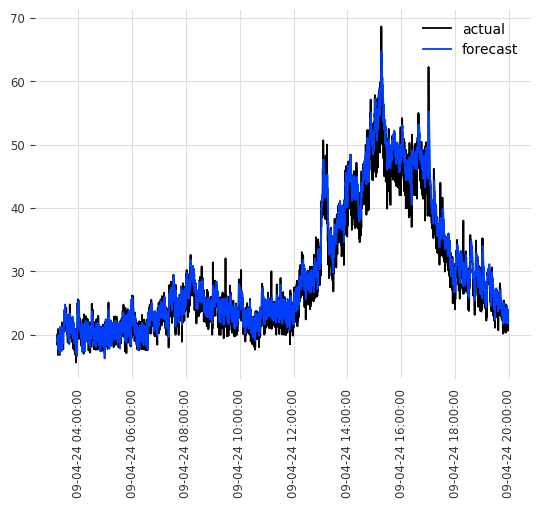

In [175]:
import matplotlib.dates as mdates

plt.plot(nbeats_pred_timeline, nbeats_target_test_plot.values(), label='actual')
plt.plot(nbeats_pred_timeline, nbeats_target_test_pred.values(), label='forecast')
# rotate x axis labels and show them as dd-mm-yy hh:mm:ss
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=90)
plt.legend()
plt.show()

# N-HiTS Model

In [51]:
from darts.models import NHiTSModel
nhits_model = NHiTSModel(
    input_chunk_length=20,
    output_chunk_length=1,
    n_epochs=2
)

In [52]:
nhits_model.fit(target_train, past_covariates=covariates_train, val_series=target_val, val_past_covariates=covariates_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.4 M 
---------------------------------------------------
1.2 M     Trainable params
123 K     Non-trainable params
1.4 M     Total params
5.414     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=20, output_chunk_length=1, n_epochs=2)

In [53]:
nhits_target_test_pred = nhits_model.historical_forecasts(
    series=target_test,
    past_covariates=covariates_test,
    forecast_horizon=1,         # forecasting one step at a time
    stride=1,                   # step taken for each forecast
    retrain=False,              # no retraining, using the pre-fit model
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [54]:
nhits_pred_blocks = list(nhits_target_test_pred.pd_dataframe().index)
nhits_pred_timeline = np.array(timestamp[nhits_pred_blocks])
nhits_target_test_plot = target[nhits_pred_blocks]

In [55]:
from darts.metrics.metrics import mape
mape(nhits_target_test_plot, nhits_target_test_pred)

4.3998327

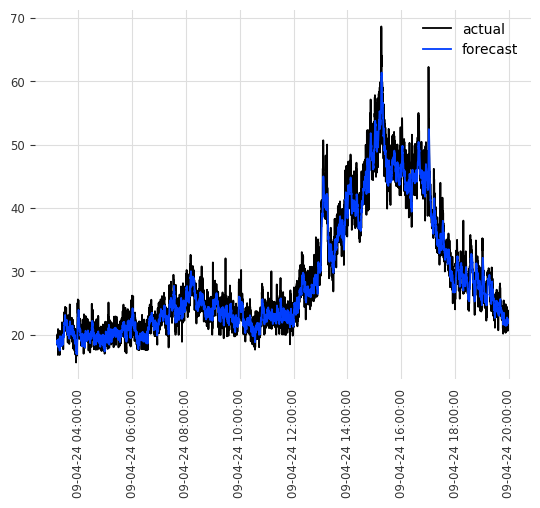

In [56]:
import matplotlib.dates as mdates

plt.plot(nhits_pred_timeline, nhits_target_test_plot.values(), label='actual')
plt.plot(nhits_pred_timeline, nhits_target_test_pred.values(), label='forecast')
# rotate x axis labels and show them as dd-mm-yy hh:mm:ss
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=90)
plt.legend()
plt.show()

# BlockRNN Model

In [65]:
from darts.models import BlockRNNModel
blockrnn_model = BlockRNNModel(
    model="GRU",
    hidden_dim=200,
    n_rnn_layers=2,
    input_chunk_length=20,
    output_chunk_length=1,
    n_epochs=2,
)

In [66]:
blockrnn_model.fit(target_train, past_covariates=covariates_train, val_series=target_val, val_past_covariates=covariates_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 369 K 
4 | fc            | Sequential       | 201   
---------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.479     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=200, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=20, output_chunk_length=1, n_epochs=2)

In [67]:
blockrnn_target_test_pred = blockrnn_model.historical_forecasts(
    series=target_test,
    past_covariates=covariates_test,
    forecast_horizon=1,         # forecasting one step at a time
    stride=1,                   # step taken for each forecast
    retrain=False,              # no retraining, using the pre-fit model
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [68]:
blockrnn_pred_blocks = list(blockrnn_target_test_pred.pd_dataframe().index)
blockrnn_pred_timeline = np.array(timestamp[blockrnn_pred_blocks])
blockrnn_target_test_plot = target[blockrnn_pred_blocks]

In [69]:
from darts.metrics.metrics import mape
mape(blockrnn_target_test_plot, blockrnn_target_test_pred)

12.787026

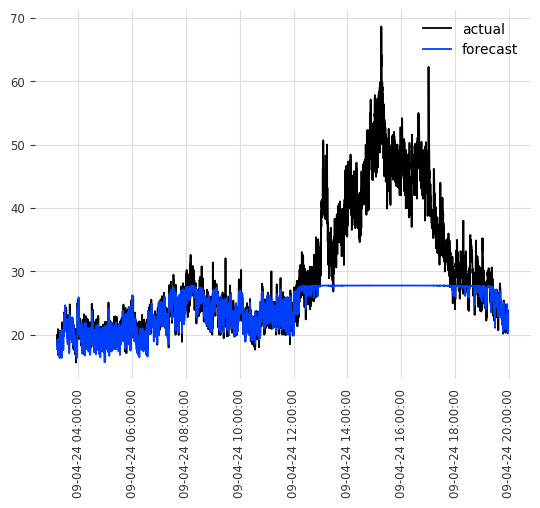

In [70]:
import matplotlib.dates as mdates

plt.plot(blockrnn_pred_timeline, blockrnn_target_test_plot.values(), label='actual')
plt.plot(blockrnn_pred_timeline, blockrnn_target_test_pred.values(), label='forecast')
# rotate x axis labels and show them as dd-mm-yy hh:mm:ss
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=90)
plt.legend()
plt.show()

# AutoARIMA Model

In [18]:
from darts.models import AutoARIMA
arima_model = AutoARIMA(
    start_p=8,
    max_p=12,
    start_q=1
    )

In [19]:
arima_model.fit(target_train)


AutoARIMA(add_encoders=None, start_p=8, max_p=12, start_q=1)

In [22]:
arima_target_test = target_test[:100]
arima_target_test_pred = arima_model.historical_forecasts(
    series=arima_target_test,
    forecast_horizon=1,         # forecasting one step at a time
    stride=1,                   # step taken for each forecast
    verbose=True
)

100%|██████████| 90/90 [02:52<00:00,  1.92s/it]


In [23]:
arima_pred_blocks = list(arima_target_test_pred.pd_dataframe().index)
arima_pred_timeline = np.array(timestamp[arima_pred_blocks])
arima_target_test_plot = target[arima_pred_blocks]

In [24]:
from darts.metrics.metrics import mape
mape(arima_target_test_plot, arima_target_test_pred)

5.07925600252788

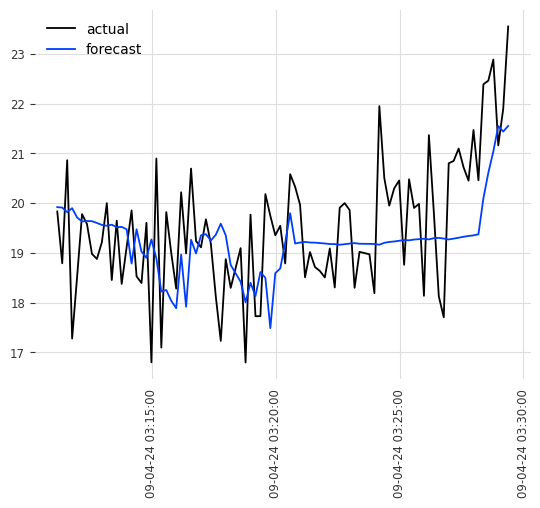

In [25]:
import matplotlib.dates as mdates

plt.plot(arima_pred_timeline, arima_target_test_plot.values(), label='actual')
plt.plot(arima_pred_timeline, arima_target_test_pred.values(), label='forecast')
# rotate x axis labels and show them as dd-mm-yy hh:mm:ss
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=90)
plt.legend()
plt.show()

# N-BEATS Model Optimization
In this section we fine-tune the N-BEATS model to increase model performance.

In [76]:
# change input chunk length
nbeats_model_10 = NBEATSModel(
    input_chunk_length=10,
    output_chunk_length=1,
    n_epochs=2,
)
nbeats_model_40 = NBEATSModel(
    input_chunk_length=40,
    output_chunk_length=1,
    n_epochs=2,
)

In [77]:
nbeats_model_10.fit(target_train, past_covariates=covariates_train, val_series=target_val, val_past_covariates=covariates_val)
nbeats_model_40.fit(target_train, past_covariates=covariates_train, val_series=target_val, val_past_covariates=covariates_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.0 M 
---------------------------------------------------
6.9 M     Trainable params
2.0 K     Non-trainable params
7.0 M     Total params
27.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.8 M 
---------------------------------------------------
9.8 M     Trainable params
4.2 K     Non-trainable params
9.8 M     Total params
39.124    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=40, output_chunk_length=1, n_epochs=2)

In [78]:
nbeats_target_test_pred_10 = nbeats_model_10.historical_forecasts(
    series=target_test,
    past_covariates=covariates_test,
    forecast_horizon=1,         # forecasting one step at a time
    stride=1,                   # step taken for each forecast
    retrain=False,              # no retraining, using the pre-fit model
    verbose=True
)

nbeats_target_test_pred_40 = nbeats_model_40.historical_forecasts(
    series=target_test,
    past_covariates=covariates_test,
    forecast_horizon=1,         # forecasting one step at a time
    stride=1,                   # step taken for each forecast
    retrain=False,              # no retraining, using the pre-fit model
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [79]:
nbeats_pred_blocks_10 = list(nbeats_target_test_pred_10.pd_dataframe().index)
nbeats_pred_timeline_10 = np.array(timestamp[nbeats_pred_blocks_10])
nbeats_target_test_plot_10 = target[nbeats_pred_blocks_10]

nbeats_pred_blocks_40 = list(nbeats_target_test_pred_40.pd_dataframe().index)
nbeats_pred_timeline_40 = np.array(timestamp[nbeats_pred_blocks_40])
nbeats_target_test_plot_40 = target[nbeats_pred_blocks_40]

In [80]:
from darts.metrics.metrics import mape
mape(nbeats_target_test_plot_10, nbeats_target_test_pred_10)

5.362803

In [81]:
from darts.metrics.metrics import mape
mape(nbeats_target_test_plot_40, nbeats_target_test_pred_40)

4.8317695

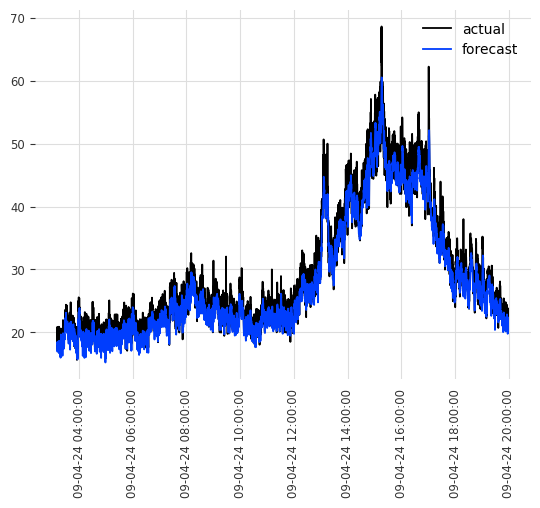

In [84]:
import matplotlib.dates as mdates

plt.plot(nbeats_pred_timeline_10, nbeats_target_test_plot_10.values(), label='actual')
plt.plot(nbeats_pred_timeline_10, nbeats_target_test_pred_10.values(), label='forecast')
# rotate x axis labels and show them as dd-mm-yy hh:mm:ss
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=90)
plt.legend()
plt.show()

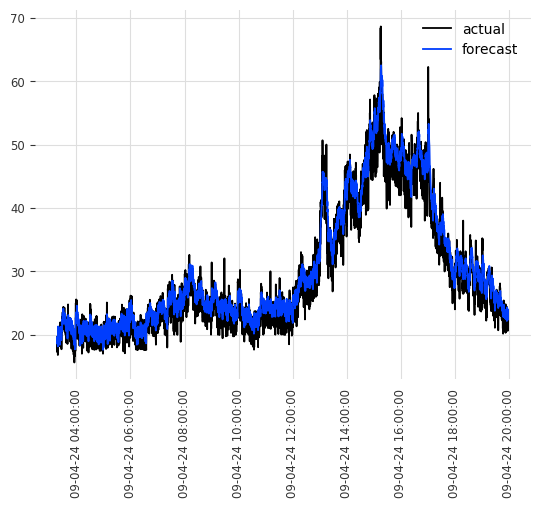

In [85]:
import matplotlib.dates as mdates

plt.plot(nbeats_pred_timeline_40, nbeats_target_test_plot_40.values(), label='actual')
plt.plot(nbeats_pred_timeline_40, nbeats_target_test_pred_40.values(), label='forecast')
# rotate x axis labels and show them as dd-mm-yy hh:mm:ss
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=90)
plt.legend()
plt.show()

As shown above, MAPE increases when we change input chunk length to 10 or 40. For an input length of 10, our model seems to underestimate changes and for a length of 40 it seems to overestimate changes. This may correspond to insufficient history and lagging prediction respectively. We continue to use an input chunk length of 20.

In [136]:
# tune number of stacks
nbeats_model_stacks = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=1,
    n_epochs=2,
    generic_architecture=True,
    num_stacks=4
)

In [137]:
nbeats_model_stacks.fit(target_train, past_covariates=covariates_train, val_series=target_val, val_past_covariates=covariates_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.1 M 
---------------------------------------------------
1.0 M     Trainable params
2.7 K     Non-trainable params
1.1 M     Total params
4.210     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=4, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=20, output_chunk_length=1, n_epochs=2)

In [138]:
nbeats_target_test_pred_stacks = nbeats_model_stacks.historical_forecasts(
    series=target_test,
    past_covariates=covariates_test,
    forecast_horizon=1,         # forecasting one step at a time
    stride=1,                   # step taken for each forecast
    retrain=False,              # no retraining, using the pre-fit model
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [139]:
nbeats_pred_blocks_stacks = list(nbeats_target_test_pred_stacks.pd_dataframe().index)
nbeats_pred_timeline_stacks = np.array(timestamp[nbeats_pred_blocks_stacks])
nbeats_target_test_plot_stacks = target[nbeats_pred_blocks_stacks]

In [140]:
from darts.metrics.metrics import mape
mape(nbeats_target_test_plot_stacks, nbeats_target_test_pred_stacks)

3.5169353

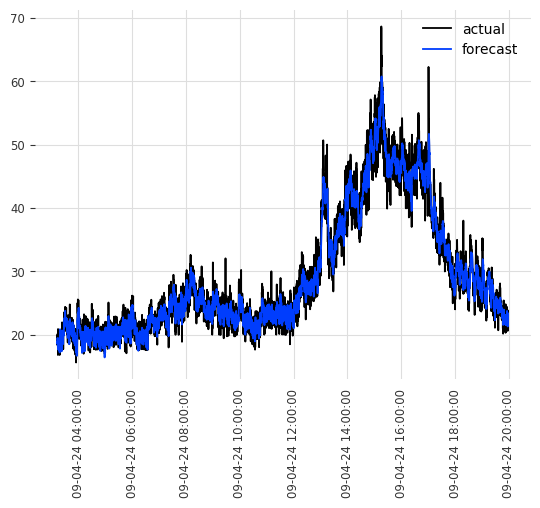

In [146]:
import matplotlib.dates as mdates

plt.plot(nbeats_pred_timeline_stacks, nbeats_target_test_plot_stacks.values(), label='actual')
plt.plot(nbeats_pred_timeline_stacks, nbeats_target_test_pred_stacks.values(), label='forecast')
# rotate x axis labels and show them as dd-mm-yy hh:mm:ss
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=90)
plt.legend()
plt.show()

In [147]:
# tune number of blocks
nbeats_model_blocks = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=1,
    n_epochs=2,
    generic_architecture=True,
    num_stacks=4,
    num_blocks=5
)

In [148]:
nbeats_model_blocks.fit(target_train, past_covariates=covariates_train, val_series=target_val, val_past_covariates=covariates_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 5.3 M 
---------------------------------------------------
5.3 M     Trainable params
2.7 K     Non-trainable params
5.3 M     Total params
21.052    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=4, num_blocks=5, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=20, output_chunk_length=1, n_epochs=2)

In [149]:
nbeats_target_test_pred_blocks = nbeats_model_blocks.historical_forecasts(
    series=target_test,
    past_covariates=covariates_test,
    forecast_horizon=1,         # forecasting one step at a time
    stride=1,                   # step taken for each forecast
    retrain=False,              # no retraining, using the pre-fit model
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [150]:
nbeats_pred_blocks_blocks = list(nbeats_target_test_pred_blocks.pd_dataframe().index)
nbeats_pred_timeline_blocks = np.array(timestamp[nbeats_pred_blocks_blocks])
nbeats_target_test_plot_blocks = target[nbeats_pred_blocks_blocks]

In [151]:
from darts.metrics.metrics import mape
mape(nbeats_target_test_plot_blocks, nbeats_target_test_pred_blocks)

3.3673286

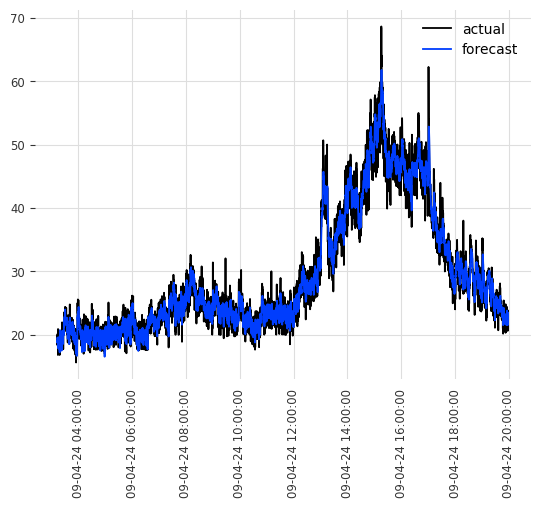

In [152]:
import matplotlib.dates as mdates

plt.plot(nbeats_pred_timeline_blocks, nbeats_target_test_plot_blocks.values(), label='actual')
plt.plot(nbeats_pred_timeline_blocks, nbeats_target_test_pred_blocks.values(), label='forecast')
# rotate x axis labels and show them as dd-mm-yy hh:mm:ss
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=90)
plt.legend()
plt.show()

In [153]:
# tune number of layers
nbeats_model_layers = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=1,
    n_epochs=2,
    generic_architecture=True,
    num_stacks=4,
    num_blocks=5,
    num_layers = 1
)

In [154]:
nbeats_model_layers.fit(target_train, past_covariates=covariates_train, val_series=target_val, val_past_covariates=covariates_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.3 M 
---------------------------------------------------
1.3 M     Trainable params
2.7 K     Non-trainable params
1.3 M     Total params
5.262     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=4, num_blocks=5, num_layers=1, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=20, output_chunk_length=1, n_epochs=2)

In [159]:
nbeats_target_test_pred_layers = nbeats_model_layers.historical_forecasts(
    series=target_test,
    past_covariates=covariates_test,
    forecast_horizon=1,         # forecasting one step at a time
    stride=1,                   # step taken for each forecast
    retrain=False,              # no retraining, using the pre-fit model
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [161]:
nbeats_pred_blocks_layers = list(nbeats_target_test_pred_layers.pd_dataframe().index)
nbeats_pred_timeline_layers = np.array(timestamp[nbeats_pred_blocks_layers])
nbeats_target_test_plot_layers = target[nbeats_pred_blocks_layers]

In [162]:
from darts.metrics.metrics import mape
mape(nbeats_target_test_plot_layers, nbeats_target_test_pred_layers)

4.0005875

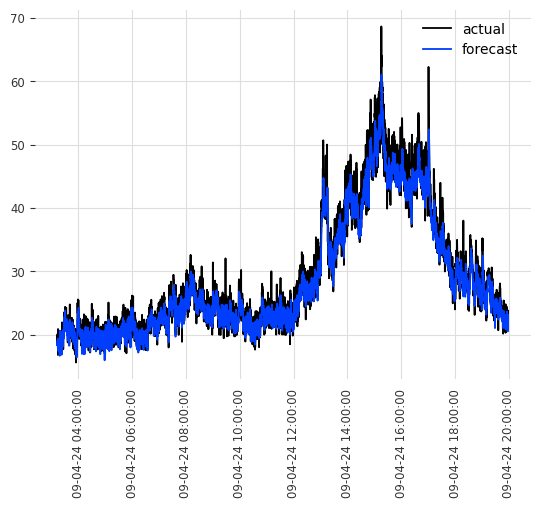

In [163]:
import matplotlib.dates as mdates

plt.plot(nbeats_pred_timeline_layers, nbeats_target_test_plot_layers.values(), label='actual')
plt.plot(nbeats_pred_timeline_layers, nbeats_target_test_pred_layers.values(), label='forecast')
# rotate x axis labels and show them as dd-mm-yy hh:mm:ss
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=90)
plt.legend()
plt.show()